In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite

### Component info

In [2]:
comp_info = np.loadtxt('../data/recipes/comp_info.tsv', dtype=str, delimiter='\t')

In [3]:
comp_info

array([['0', 'jasmone', '488-10-8'],
       ['1', '5-methylhexanoic_acid', '628-46-6'],
       ['2', 'l-glutamine', '56-85-9'],
       ...,
       ['1104', 'guaiacol', '90-05-1'],
       ['1105', '(+/?)-methyl_5-acetoxyhexanoate', '35234-22-1'],
       ['1106', 'ethyl_sorbate', '2396-84-1']], dtype='<U93')

In [4]:
id_comp_dict = dict()
for line in comp_info:
    id_comp_dict[int(line[0])] = line[1]
comp_id_dict = {v:k for k, v in id_comp_dict.items()}

### Ingredient info

In [5]:
ingr_info = np.loadtxt('../data/recipes/ingr_info.tsv', dtype=str, delimiter='\t')

In [6]:
ingr_info

array([['0', 'magnolia_tripetala', 'flower'],
       ['1', 'calyptranthes_parriculata', 'plant'],
       ['2', 'chamaecyparis_pisifera_oil', 'plant derivative'],
       ...,
       ['1527', 'green_tea', 'plant derivative'],
       ['1528', 'artemisia_porrecta_oil', 'plant derivative'],
       ['1529', 'munster_cheese', 'dairy']], dtype='<U35')

In [7]:
id_ingr_dict = dict()
for line in ingr_info:
    id_ingr_dict[int(line[0])] = line[1]
ingr_id_dict = {v:k for k, v in id_ingr_dict.items()}

### Recipes and regions

In [8]:
recipes_dict = dict()
regions_dict = dict()

In [9]:
with open('../data/recipes/menu_recipes.txt') as f:
    for i, line in enumerate(f):
        alist = line.rstrip('\n').split()
        region = alist[0]
        ingr = alist[1:]
        regions_dict[i] = region
        recipes_dict[i] = ingr

In [10]:
id_region_dict = dict()
region_id_dict = dict()
for i, region in enumerate(set(regions_dict.values())):
    id_region_dict[i] = region
    region_id_dict[region] = i

### Region/recipe biadjacency matrix

In [11]:
bmat_region_recipe = np.zeros((len(id_region_dict), len(recipes_dict)))
for recipe, region in regions_dict.items():
    j = recipe
    i = region_id_dict[region]
    bmat_region_recipe[i, j] = 1

In [12]:
bmat_region_recipe.shape

(8, 2458)

### Recipe/ingredient biadjacency matrix

In [13]:
bmat_recipe_ingr = np.zeros((len(recipes_dict), len(id_ingr_dict)))
for recipe, ingreds in recipes_dict.items():
    i = recipe
    jlist = [ingr_id_dict[x] for x in ingreds]
    bmat_recipe_ingr[i, jlist] = 1

In [14]:
print([id_ingr_dict[x] for x in np.argwhere(bmat_recipe_ingr[0]).flatten()])
print(recipes_dict[0])

['sesame_oil', 'garlic', 'lettuce', 'beef', 'sake', 'beef_broth', 'scallion', 'oyster', 'vegetable_oil', 'soy_sauce', 'starch', 'onion']
['onion', 'beef', 'starch', 'sake', 'soy_sauce', 'scallion', 'lettuce', 'garlic', 'vegetable_oil', 'beef_broth', 'oyster', 'sesame_oil']


In [15]:
bmat_recipe_ingr.shape

(2458, 1530)

### Ingredient/compound biadjacency matrix

In [16]:
ingr_comp = np.loadtxt('../data/recipes/ingr_comp.tsv', dtype=int, delimiter='\t')

In [17]:
ingr_comp

array([[1392,  906],
       [1259,  861],
       [1079,  673],
       ...,
       [ 689,  650],
       [ 689,  297],
       [1080,   13]])

In [18]:
bmat_ingr_comp = np.zeros((len(id_ingr_dict), len(id_comp_dict)))
for item in ingr_comp:
    i, j = item
    bmat_ingr_comp[i, j] = 1

In [19]:
print(bmat_ingr_comp[1392, 906])
print(bmat_ingr_comp[1392, 907])

1.0
0.0


In [20]:
bmat_ingr_comp.shape

(1530, 1107)

### Setup for link prediction

In [21]:
import os
import sys
linkpred_path = os.path.abspath(os.path.join('../linkpred/'))
if linkpred_path not in sys.path:
    sys.path.append(linkpred_path)

import b_lcp, b_mi, b_probas, b_si, b_util, b_val

In [22]:
fraction = 0.1
loops = 100 #1
verbose=True
plot=True

In [23]:
# Precompute links to delete for all datasets
links_to_del_region_recipe = b_val.get_links_to_del(bmat_region_recipe, fraction=fraction, loops=loops)
links_to_del_recipe_ingr = b_val.get_links_to_del(bmat_recipe_ingr, fraction=fraction, loops=loops)
links_to_del_ingr_comp = b_val.get_links_to_del(bmat_ingr_comp, fraction=fraction, loops=loops)

# Jorge's approach:
## to calculate ALL the scores for a given dataset and deleted links, then call it in the next functions

In [24]:
def delete_links(x, links_to_del):
    """Deletes the specified links from an adjacency matrix."""
    x_ = np.copy(x)
    for link in links_to_del:
        x_[link[0], link[1]] = 0
        
    return x_

In [ ]:
bmat_recipe_ingr.shape

In [ ]:
links_to_del_recipe_ingr.shape

In [62]:
scores_list = []
for i in range(1):#loops):    
    x_ = delete_links(bmat_recipe_ingr, links_to_del_recipe_ingr[i])
    missing = np.argwhere(x_ == 0)
    ## SAVE ALL THE SCORES:
    lcp_scores = b_lcp.bipartite_lcp_all(x_, missing, verbose=verbose)
    scores_list.append(lcp_scores)
scores_array = np.array(scores_list)

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))


100.00 %, 4.11 minutes


In [ ]:
scores_array.shape

In [ ]:
assert links_to_del_recipe_ingr.shape[0] == loops

In [63]:
metrics_list = ['lcl', 'cn', 'jc', 'car', 'cjc', 'cpa', 'ra', 'aa', 'cra', 'caa', 'cpi']

def cross_val(scores, metric, loops=1, raw_output=False, verbose=True, plot=False):
    if raw_output:
        scores_list = []
        true_list = []
    else:
        results = np.zeros((loops, 2))

    for i in range(loops):
        if verbose:
            print('Trial {} of {}'.format(i + 1, loops))
        x_ = delete_links(bmat_recipe_ingr, links_to_del_recipe_ingr[i])
        missing = np.argwhere(x_ == 0)
        true = bmat_recipe_ingr[missing[:,0], missing[:,1]]
        
        score = scores_array[i, metrics_list.index(metric)]
        
        if raw_output:
            scores_list.append(score)
            true_list.append(true)
        else:
            results[i] = b_val.evaluate_predictions(true, score, plot=plot)
        
    if raw_output:
        return true_list, scores_list
    else:
        return results

Trial 1 of 1


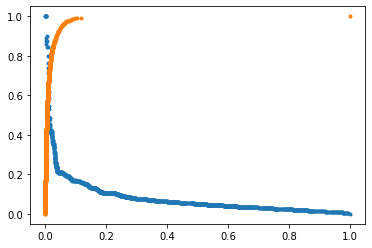

[0.08077459 0.98405654]
[0. 0.]


In [64]:
r_cn = cross_val(lcp_scores, 'cn', loops=1, verbose=verbose, plot=plot)
print(np.mean(r_cn, axis=0))
print(np.std(r_cn, axis=0))

In [65]:
r_cn

array([[0.08077459, 0.98405654]])

Trial 1 of 1


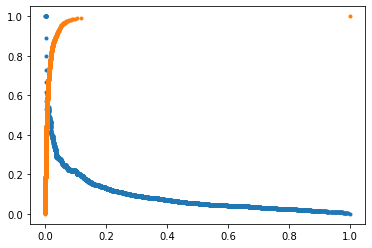

[0.0896664  0.98454393]
[0. 0.]


In [66]:
r_lcl = cross_val(lcp_scores, 'lcl', loops=1, verbose=verbose, plot=plot)
print(np.mean(r_lcl, axis=0))
print(np.std(r_lcl, axis=0))

In [67]:
r_lcl

array([[0.0896664 , 0.98454393]])

### Recipe-Ingredient

In [68]:
# CN
r01 = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cn',), mode='lcp', loops=1, verbose=verbose, plot=plot)
print(np.mean(r01, axis=0))
print(np.std(r01, axis=0))

AssertionError: 

In [ ]:
# LCL
r02 = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('lcl',), mode='lcp', loops=1, verbose=verbose, plot=plot)
print(np.mean(r02, axis=0))
print(np.std(r02, axis=0))

# IT WORKS!
## Now I have to parallelize the trials

In [25]:
import time

In [26]:
import dask

In [27]:
from dask import delayed  # DON'T CHANGE (explained later)

def func(i):
    print(f'Trial {i} starting...')
    scores_list = []
    x_ = delete_links(bmat_recipe_ingr, links_to_del_recipe_ingr[i])
    missing = np.argwhere(x_ == 0)
    lcp_scores = b_lcp.bipartite_lcp_all(x_, missing, verbose=verbose)
    scores_list.append(lcp_scores)
    print(f'... Trial {i} done')
    return scores_list

#loops = 2
#lazy = [delayed(func)(i) for i in range(2)]#loops)]  # DON'T CHANGE (explained later)

In [ ]:
#dask.visualize(lazy)

In [ ]:
"""%%time
start = time.time()
scheduler = 'single-threaded'
res = dask.compute(lazy, scheduler=scheduler)
print(res)

print(time.time()-start, "seconds")"""

In [ ]:
"""%%time
start = time.time()
scheduler = 'threads'
res = dask.compute(lazy, scheduler=scheduler)
print(res)

print(time.time()-start, "seconds")"""

In [ ]:
"""%%time
start = time.time()
scheduler = 'processes'
res = dask.compute(lazy, scheduler=scheduler)
print(res)

print(time.time()-start, "seconds")"""

In [ ]:
#res[0]#.shape

In [ ]:
#for r, rr in enumerate(res[0]):
#    print(r, rr[0])

In [ ]:
#res[0][0][0].shape

In [ ]:
#res[0][0][0].shape[1]

In [ ]:
#res[0][1][0].shape

# DON'T RUN the next line again, it takes a couple of hours to create the 100 npy files

In [30]:
loops = 100
sub_loops = int(np.sqrt(loops))
#C = np.zeros((loops, res[0][0][0].shape[0], res[0][0][0].shape[1]))
#C = np.zeros((loops, 11, 3741081))

k = 0
for i in range(sub_loops):
    l = []
    kk = k
    for j in range(sub_loops):
        l.append(k)
        k += 1
    lazy = [delayed(func)(kkk) for kkk in range(kk, k)]
    res = dask.compute(lazy, scheduler='processes')
    for r, rr in enumerate(res[0]):
        A = rr[0]
        np.save('{}_array'.format(l[r]), A)
        del A
        #C[l[r],:,:] = np.load('{}_array.npy'.format(l[r]))

Trial 9 starting...
Trial 8 starting...
Trial 4 starting...
Trial 5 starting...
Trial 2 starting...
Trial 0 starting...
Trial 3 starting...
Trial 7 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarnin

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in do

Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in do

100.00 %, 12.23 minutes
... Trial 7 done
Trial 6 starting...
Computing bipartite LCP
100.00 %, 12.36 minutes
... Trial 0 done
100.00 %, 12.44 minutes
... Trial 2 done
Trial 1 starting...
Computing bipartite LCP
100.00 %, 12.52 minutes
... Trial 9 done
100.00 %, 12.54 minutes
... Trial 5 done
100.00 %, 12.58 minutes
... Trial 4 done
100.00 %, 12.59 minutes
... Trial 8 done
100.00 %, 12.64 minutes
... Trial 3 done
100.00 %, 4.59 minutes
... Trial 6 done
100.00 %, 4.50 minutes
... Trial 1 done
Trial 15 starting...
Trial 12 starting...
Trial 11 starting...
Trial 17 starting...
Trial 18 starting...
Trial 10 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Trial 13 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)


Trial 19 starting...


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in do

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountere

100.00 %, 12.43 minutes
... Trial 17 done
Trial 14 starting...
Computing bipartite LCP
100.00 %, 12.55 minutes
... Trial 11 done
Trial 16 starting...
Computing bipartite LCP
100.00 %, 12.68 minutes
... Trial 12 done
100.00 %, 12.73 minutes
... Trial 10 done
100.00 %, 12.80 minutes
100.00 %, 12.77 minutes
... Trial 15 done
... Trial 13 done
100.00 %, 12.78 minutes
... Trial 19 done
100.00 %, 12.97 minutes
... Trial 18 done
100.00 %, 4.41 minutes
... Trial 14 done
100.00 %, 4.35 minutes
... Trial 16 done
Trial 26 starting...
Trial 24 starting...
Trial 20 starting...
Trial 21 starting...
Trial 28 starting...
Trial 22 starting...
Trial 23 starting...
Trial 27 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP
Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP
Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning

100.00 %, 12.29 minutes
100.00 %, 12.30 minutes
... Trial 24 done
... Trial 23 done
100.00 %, 12.30 minutes
... Trial 27 done
100.00 %, 12.35 minutes
... Trial 22 done
Trial 29 starting...
100.00 %, 12.40 minutes
... Trial 20 done
Computing bipartite LCP
100.00 %, 12.40 minutes
... Trial 26 done
Trial 25 starting...
Computing bipartite LCP
100.00 %, 12.45 minutes
... Trial 21 done
100.00 %, 12.59 minutes
... Trial 28 done
100.00 %, 4.27 minutes
... Trial 29 done
100.00 %, 4.24 minutes
... Trial 25 done
Trial 36 starting...
Trial 30 starting...
Trial 35 starting...
Trial 39 starting...
Trial 38 starting...
Trial 32 starting...
Trial 37 starting...
Trial 33 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP
Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scal

100.00 %, 12.13 minutes
... Trial 33 done
100.00 %, 12.15 minutes
100.00 %, 12.15 minutes
... Trial 36 done
... Trial 30 done
100.00 %, 12.17 minutes
... Trial 32 done
100.00 %, 12.22 minutes
... Trial 39 done
Trial 34 starting...
Computing bipartite LCP
Trial 31 starting...
Computing bipartite LCP
100.00 %, 12.29 minutes
... Trial 35 done
100.00 %, 12.33 minutes
... Trial 38 done
100.00 %, 12.37 minutes
... Trial 37 done
100.00 %, 4.23 minutes
... Trial 34 done
100.00 %, 4.29 minutes
... Trial 31 done
Trial 43 starting...
Trial 48 starting...
Trial 46 starting...
Trial 44 starting...
Trial 42 starting...
Trial 40 starting...
Computing bipartite LCP
Trial 47 starting...


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Trial 49 starting...


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav =

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.s

100.00 %, 12.20 minutes
... Trial 44 done
100.00 %, 12.26 minutes
... Trial 40 done
100.00 %, 12.30 minutes
... Trial 43 done
100.00 %, 12.29 minutes
Trial 45 starting...
100.00 %, 12.29 minutes
... Trial 42 done
... Trial 47 done
Computing bipartite LCP
100.00 %, 12.47 minutes
... Trial 46 done
100.00 %, 12.48 minutes
... Trial 49 done
100.00 %, 12.63 minutes
Trial 41 starting...
... Trial 48 done
Computing bipartite LCP
100.00 %, 4.82 minutes
... Trial 45 done
100.00 %, 4.66 minutes
... Trial 41 done
Trial 56 starting...
Trial 53 starting...
Trial 55 starting...
Trial 54 starting...
Trial 57 starting...
Trial 52 starting...
Trial 59 starting...
Trial 50 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP
Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scal

100.00 %, 13.18 minutes
... Trial 57 done
Trial 58 starting...
100.00 %, 13.28 minutes
... Trial 52 done
Computing bipartite LCP
100.00 %, 13.36 minutes
... Trial 54 done
100.00 %, 13.38 minutes
... Trial 55 done
Trial 51 starting...
Computing bipartite LCP
100.00 %, 13.43 minutes
... Trial 56 done
100.00 %, 13.43 minutes
... Trial 50 done
100.00 %, 13.47 minutes
... Trial 53 done
100.00 %, 13.48 minutes
... Trial 59 done
100.00 %, 4.62 minutes
... Trial 58 done
100.00 %, 4.53 minutes
... Trial 51 done
Trial 66 starting...
Trial 68 starting...
Trial 63 starting...
Trial 65 starting...
Trial 67 starting...
Trial 69 starting...
Trial 60 starting...
Trial 62 starting...
Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encounte

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in do

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in 

100.00 %, 13.26 minutes
... Trial 60 done
100.00 %, 13.28 minutes
... Trial 66 done
100.00 %, 13.32 minutes
... Trial 62 done
100.00 %, 13.34 minutes
... Trial 67 done
100.00 %, 13.35 minutes
Trial 64 starting...
... Trial 68 done
Computing bipartite LCP
Trial 61 starting...
100.00 %, 13.40 minutes
... Trial 65 done
Computing bipartite LCP
100.00 %, 13.42 minutes
... Trial 63 done
100.00 %, 13.45 minutes
... Trial 69 done
100.00 %, 4.50 minutes
... Trial 61 done
100.00 %, 4.56 minutes
... Trial 64 done
Trial 72 starting...
Trial 76 starting...
Trial 73 starting...
Trial 74 starting...
Trial 78 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Trial 79 starting...


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Trial 70 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Trial 75 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encounte

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x

100.00 %, 13.03 minutes
... Trial 78 done
Trial 77 starting...
Computing bipartite LCP
100.00 %, 13.15 minutes
... Trial 79 done
100.00 %, 13.21 minutes
... Trial 76 done
100.00 %, 13.22 minutes
... Trial 70 done
100.00 %, 13.23 minutes
... Trial 75 done
Trial 71 starting...
Computing bipartite LCP
100.00 %, 13.33 minutes
... Trial 72 done
100.00 %, 13.34 minutes
... Trial 73 done
100.00 %, 13.40 minutes
... Trial 74 done
100.00 %, 4.59 minutes
... Trial 77 done
100.00 %, 4.48 minutes
... Trial 71 done
Trial 80 starting...
Trial 81 starting...
Trial 85 starting...
Trial 83 starting...
Trial 86 starting...
Trial 84 starting...
Trial 88 starting...
Computing bipartite LCP
Trial 89 starting...


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarnin

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav =

Computing bipartite LCP
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encounte

100.00 %, 13.19 minutes
... Trial 86 done
100.00 %, 13.25 minutes
... Trial 80 done
100.00 %, 13.25 minutes
... Trial 83 done
100.00 %, 13.27 minutes
... Trial 85 done
100.00 %, 13.28 minutes
... Trial 88 done
Trial 82 starting...
Computing bipartite LCP
Trial 87 starting...
Computing bipartite LCP
100.00 %, 13.34 minutes
... Trial 89 done
100.00 %, 13.42 minutes
... Trial 81 done
100.00 %, 13.41 minutes
... Trial 84 done
100.00 %, 4.45 minutes
... Trial 87 done
100.00 %, 4.51 minutes
... Trial 82 done
Trial 95 starting...
Trial 97 starting...
Trial 90 starting...
Trial 98 starting...
Trial 99 starting...
Trial 91 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Trial 92 starting...


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Trial 94 starting...
Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarni

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)


Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarnin

Computing bipartite LCP


/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/home/jorge/Documents/2019/Camerino/ASSP2019/multipartite-weighted-link-prediction/linkpred/b_lcp.py:100: RuntimeWarning: divide by zero encountere

100.00 %, 12.77 minutes
... Trial 99 done
Trial 93 starting...
100.00 %, 12.87 minutes
... Trial 91 done
Computing bipartite LCP
100.00 %, 12.94 minutes
... Trial 97 done
100.00 %, 12.96 minutes
... Trial 98 done
Trial 96 starting...
Computing bipartite LCP
100.00 %, 12.98 minutes
... Trial 94 done
100.00 %, 13.03 minutes
... Trial 90 done
100.00 %, 13.05 minutes
... Trial 95 done
100.00 %, 13.07 minutes
... Trial 92 done
100.00 %, 4.29 minutes
... Trial 93 done
100.00 %, 4.19 minutes
... Trial 96 done


In [31]:
#C.shape

In [40]:
ttt = 0
B = np.load('{}_array.npy'.format(ttt))

In [41]:
from scipy.sparse import csr_matrix
S = csr_matrix(B)
S

<11x3741081 sparse matrix of type '<class 'numpy.float64'>'
	with 4806703 stored elements in Compressed Sparse Row format>

In [42]:
import scipy.sparse
scipy.sparse.save_npz('sparse_test.npz', S) # weight reduced in more than 90%!

In [47]:
B.shape

(11, 3741081)

In [51]:
def cross_val_from_npy(metric, loops=1, raw_output=False, verbose=True, plot=False):
    if raw_output:
        scores_list = []
        true_list = []
    else:
        results = np.zeros((loops, 2))

    for i in range(loops):
        if verbose:
            print('Trial {} of {}'.format(i+1, loops))
        x_ = delete_links(bmat_recipe_ingr, links_to_del_recipe_ingr[i])
        missing = np.argwhere(x_ == 0)
        true = bmat_recipe_ingr[missing[:,0], missing[:,1]]
        
        specific_array = np.load('{}_array.npy'.format(i))
        score = specific_array[metrics_list.index(metric)]
        
        if raw_output:
            scores_list.append(score)
            true_list.append(true)
        else:
            results[i] = b_val.evaluate_predictions(true, score, plot=plot)
        
    if raw_output:
        return true_list, scores_list
    else:
        return results

In [92]:
r['cn']

array([[0.08077459, 0.98405654],
       [0.08759522, 0.98478481]])

In [71]:
r_cn = cross_val_from_npy('cn', loops=100, verbose=verbose)
print(np.mean(r_cn, axis=0))
print(np.std(r_cn, axis=0))

Trial 1 of 100
Trial 2 of 100
Trial 3 of 100
Trial 4 of 100
Trial 5 of 100
Trial 6 of 100
Trial 7 of 100
Trial 8 of 100
Trial 9 of 100
Trial 10 of 100
Trial 11 of 100
Trial 12 of 100
Trial 13 of 100
Trial 14 of 100
Trial 15 of 100
Trial 16 of 100
Trial 17 of 100
Trial 18 of 100
Trial 19 of 100
Trial 20 of 100
Trial 21 of 100
Trial 22 of 100
Trial 23 of 100
Trial 24 of 100
Trial 25 of 100
Trial 26 of 100
Trial 27 of 100
Trial 28 of 100
Trial 29 of 100
Trial 30 of 100
Trial 31 of 100
Trial 32 of 100
Trial 33 of 100
Trial 34 of 100
Trial 35 of 100
Trial 36 of 100
Trial 37 of 100
Trial 38 of 100
Trial 39 of 100
Trial 40 of 100
Trial 41 of 100
Trial 42 of 100
Trial 43 of 100
Trial 44 of 100
Trial 45 of 100
Trial 46 of 100
Trial 47 of 100
Trial 48 of 100
Trial 49 of 100
Trial 50 of 100
Trial 51 of 100
Trial 52 of 100
Trial 53 of 100
Trial 54 of 100
Trial 55 of 100
Trial 56 of 100
Trial 57 of 100
Trial 58 of 100
Trial 59 of 100
Trial 60 of 100
Trial 61 of 100
Trial 62 of 100
Trial 63 of 100
T

In [72]:
r_cn

array([[0.08077459, 0.98405654],
       [0.08759522, 0.98478481],
       [0.08334568, 0.98485239],
       [0.08452083, 0.98463139],
       [0.08821127, 0.98696737],
       [0.08915611, 0.9858666 ],
       [0.08388223, 0.98519156],
       [0.0812355 , 0.98432618],
       [0.08120783, 0.984684  ],
       [0.09201036, 0.98512981],
       [0.0782359 , 0.98595436],
       [0.08248386, 0.9856547 ],
       [0.08763319, 0.98569111],
       [0.08157093, 0.98497916],
       [0.07521312, 0.98421525],
       [0.0913982 , 0.98604033],
       [0.08661671, 0.9862178 ],
       [0.07985223, 0.98386374],
       [0.08595207, 0.9853543 ],
       [0.08390146, 0.9858009 ],
       [0.07680637, 0.98589851],
       [0.08356604, 0.9870865 ],
       [0.07190807, 0.98457234],
       [0.08056781, 0.98474761],
       [0.08890249, 0.98458146],
       [0.07953057, 0.98540848],
       [0.08263866, 0.98600378],
       [0.09251243, 0.98699781],
       [0.07946509, 0.98603431],
       [0.08258982, 0.98421947],
       [0.

In [ ]:
metrics_list = ['lcl', 'cn', 'jc', 'car', 'cjc', 'cpa', 'ra', 'aa', 'cra', 'caa', 'cpi']

r = {}
for m in metrics_list:
    print('Calculating r_{}'.format(m))
    r[m] = cross_val_from_npy(m, loops=100, verbose=verbose)
    #print(r[m])
    print('Mean', np.mean(r[m], axis=0))
    print('Stdv', np.std(r[m], axis=0))
    print('Ended r_{}\n'.format(m))

Calculating r_lcl
Trial 1 of 100
Trial 2 of 100
Trial 3 of 100
Trial 4 of 100
Trial 5 of 100
Trial 6 of 100
Trial 7 of 100
Trial 8 of 100
Trial 9 of 100
Trial 10 of 100
Trial 11 of 100
Trial 12 of 100
Trial 13 of 100
Trial 14 of 100
Trial 15 of 100
Trial 16 of 100
Trial 17 of 100
Trial 18 of 100
Trial 19 of 100
Trial 20 of 100
Trial 21 of 100
Trial 22 of 100
Trial 23 of 100
Trial 24 of 100
Trial 25 of 100
Trial 26 of 100
Trial 27 of 100
Trial 28 of 100
Trial 29 of 100
Trial 30 of 100
Trial 31 of 100
Trial 32 of 100
Trial 33 of 100
Trial 34 of 100
Trial 35 of 100
Trial 36 of 100
Trial 37 of 100
Trial 38 of 100
Trial 39 of 100
Trial 40 of 100
Trial 41 of 100
Trial 42 of 100
Trial 43 of 100
Trial 44 of 100
Trial 45 of 100
Trial 46 of 100
Trial 47 of 100
Trial 48 of 100
Trial 49 of 100
Trial 50 of 100
Trial 51 of 100
Trial 52 of 100
Trial 53 of 100
Trial 54 of 100
Trial 55 of 100
Trial 56 of 100
Trial 57 of 100
Trial 58 of 100
Trial 59 of 100
Trial 60 of 100
Trial 61 of 100
Trial 62 of 100

Trial 93 of 100
Trial 94 of 100
Trial 95 of 100
Trial 96 of 100
Trial 97 of 100
Trial 98 of 100
Trial 99 of 100
Trial 100 of 100
Mean [0.09230254 0.98535752]
Stdv [0.00515304 0.00096304]
Ended r_cjc

Calculating r_cpa
Trial 1 of 100
Trial 2 of 100
Trial 3 of 100
Trial 4 of 100
Trial 5 of 100
Trial 6 of 100
Trial 7 of 100
Trial 8 of 100
Trial 9 of 100
Trial 10 of 100
Trial 11 of 100
Trial 12 of 100
Trial 13 of 100
Trial 14 of 100
Trial 15 of 100
Trial 16 of 100
Trial 17 of 100
Trial 18 of 100
Trial 19 of 100
Trial 20 of 100
Trial 21 of 100
Trial 22 of 100
Trial 23 of 100
Trial 24 of 100
Trial 25 of 100
Trial 26 of 100
Trial 27 of 100
Trial 28 of 100
Trial 29 of 100
Trial 30 of 100
Trial 31 of 100
Trial 32 of 100
Trial 33 of 100
Trial 34 of 100
Trial 35 of 100
Trial 36 of 100
Trial 37 of 100
Trial 38 of 100
Trial 39 of 100
Trial 40 of 100
Trial 41 of 100
Trial 42 of 100
Trial 43 of 100
Trial 44 of 100
Trial 45 of 100
Trial 46 of 100
Trial 47 of 100
Trial 48 of 100
Trial 49 of 100
Trial 5

In [ ]:
# JC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('jc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CJC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cjc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CRA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CAR
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# RA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('ra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CPA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cpa',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# MI links
r = b_val.cross_val(b_si.si_scores, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *(b_probas.proba_comb_links_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# MI degree
r = b_val.cross_val(b_si.si_scores, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *(b_probas.proba_comb_deg_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

### Ingredient-Compound

In [ ]:
# CN
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# LCL
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('lcl',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# JC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('jc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CJC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cjc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CRA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CAR
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# RA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('ra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CPA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cpa',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# MI links
r = b_val.cross_val(b_si.si_scores, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *(b_probas.proba_comb_links_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# MI degree
r = b_val.cross_val(b_si.si_scores, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *(b_probas.proba_comb_deg_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))